In [1]:
# ============================================
# LOAN PREDICTION ML PROJECT
# Clean & Organized Version
# ============================================

In [2]:
# ===============================
# 1️⃣ IMPORT LIBRARIES & SETUPS
# ===============================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")  # Clean style for plots

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Feature Selection
from sklearn.feature_selection import RFE

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# ===============================
# 2️⃣ LOAD DATA
# ===============================
import kagglehub
dataset_path = kagglehub.dataset_download("ninzaami/loan-predication")
print("Dataset Path:", dataset_path)

# Load CSV
df = pd.read_csv(os.path.join(dataset_path, 'train_u6lujuX_CVtuZ9i (1).csv'))
print("Dataset Shape:", df.shape)
df.head()

# Target column
TARGET = "Loan_Status"

100%|██████████| 7.83k/7.83k [00:00<00:00, 2.30MB/s]

Extracting files...
Dataset Path: /root/.cache/kagglehub/datasets/ninzaami/loan-predication/versions/1
Dataset Shape: (614, 13)


In [4]:
# ===============================
# 3️⃣ DATA CLEANING
# ===============================
# Drop ID column
df.drop(columns=['Loan_ID'], inplace=True)

# Fill missing values
categorical_cols = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']
numerical_cols = ['LoanAmount', 'Loan_Amount_Term']

for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

print("Missing values after cleaning:\n", df.isnull().sum())

Missing values after cleaning:
 Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


/tmp/ipython-input-1985712585.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-1985712585.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

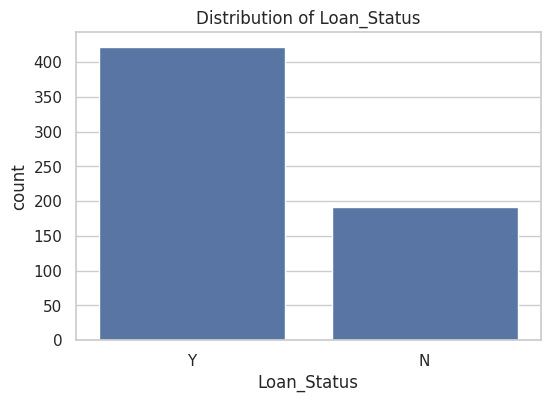

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64


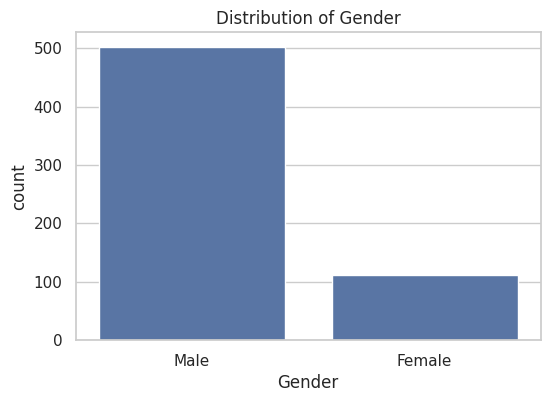

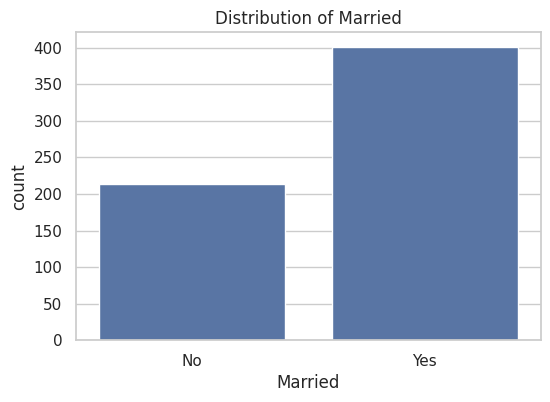

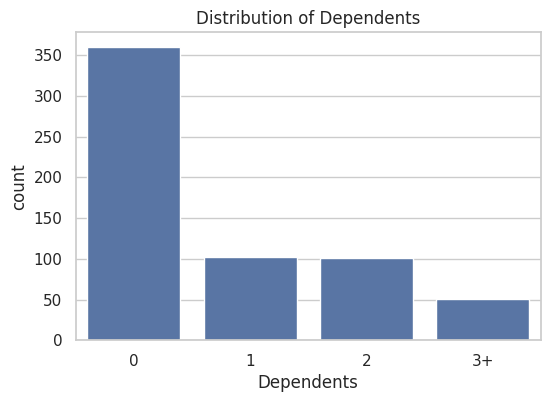

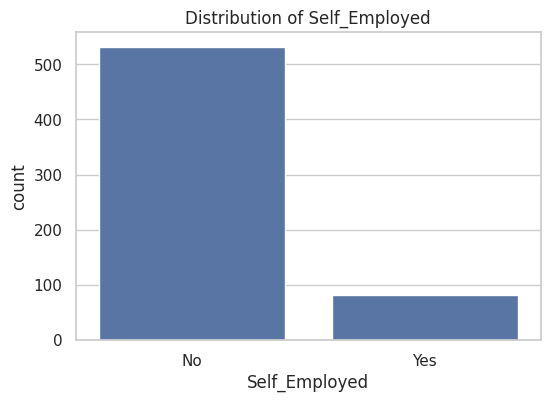

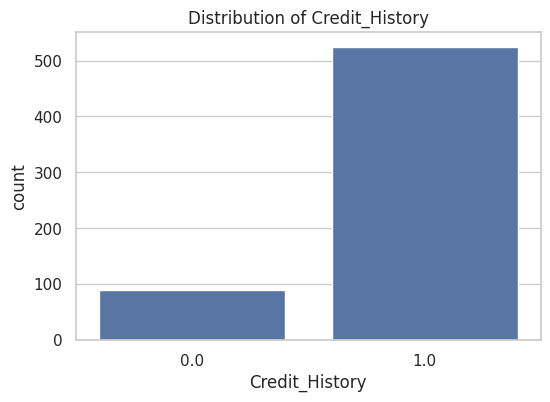

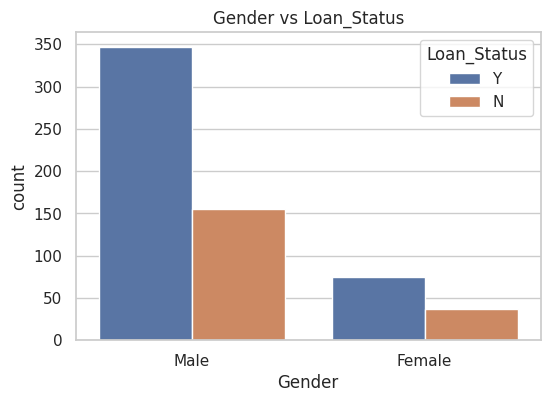

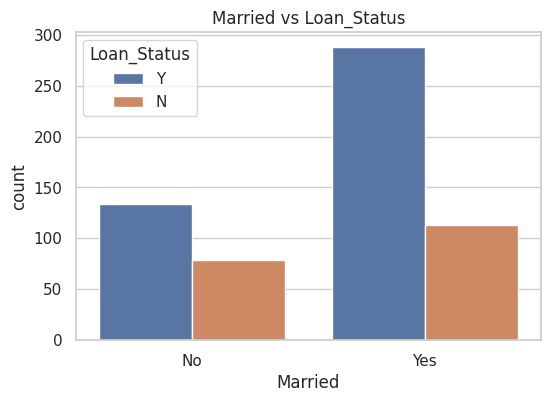

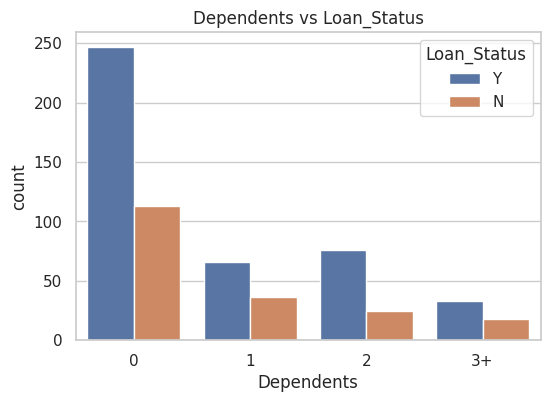

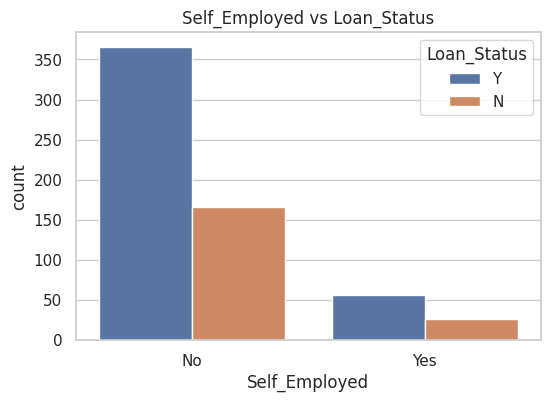

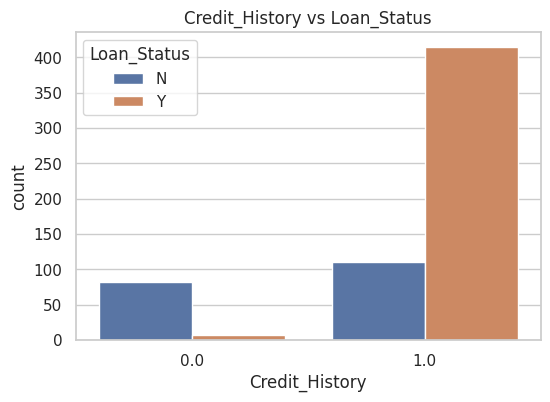

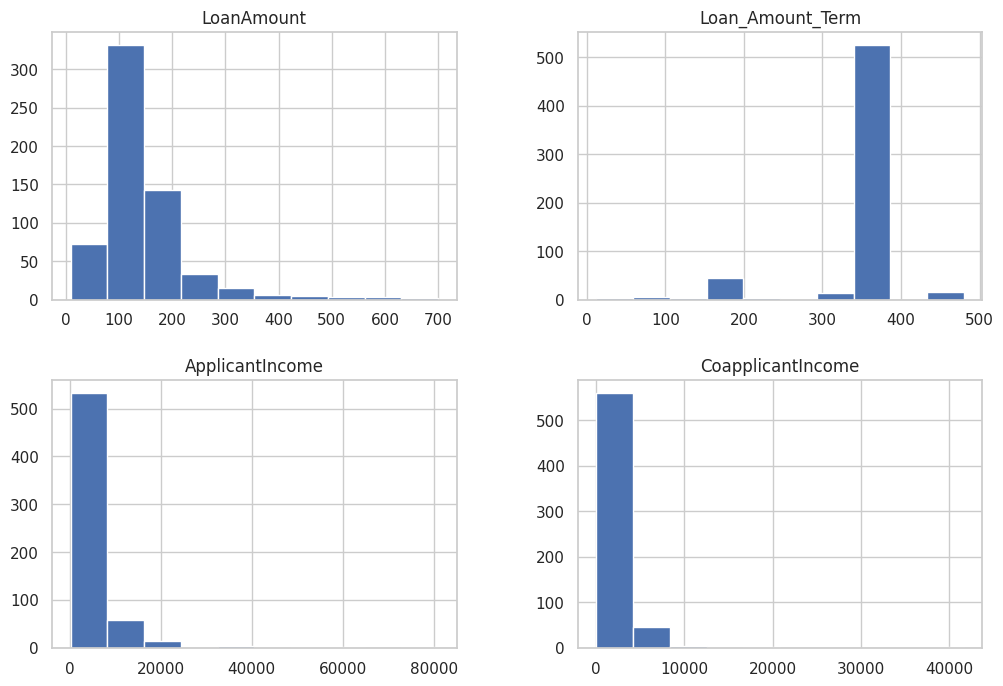

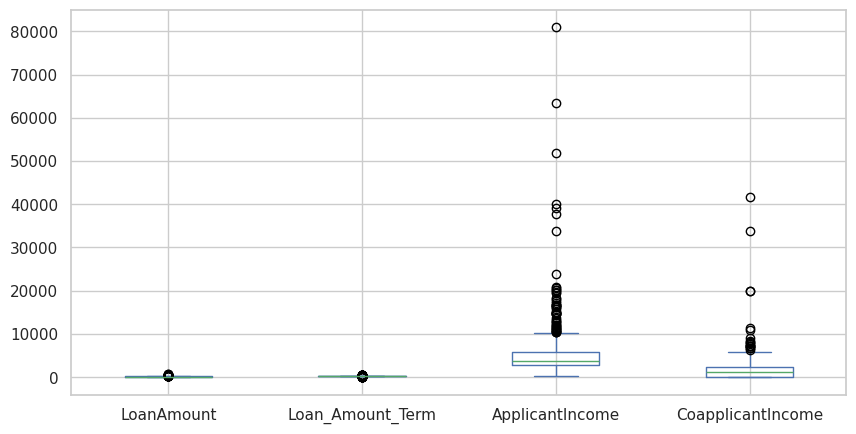

In [5]:
# ===============================
# 4️⃣ EXPLORATORY DATA ANALYSIS
# ===============================

def plot_count(col):
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.show()

# Target Distribution
plot_count(TARGET)
print(df[TARGET].value_counts(normalize=True))

# Categorical columns distribution
for col in categorical_cols:
    plot_count(col)

# Categorical vs Target
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue=TARGET, data=df)
    plt.title(f"{col} vs {TARGET}")
    plt.show()

# Numerical Features
df[numerical_cols + ['ApplicantIncome', 'CoapplicantIncome']].hist(figsize=(12,8))
plt.show()

# Boxplots for outlier detection
df[numerical_cols + ['ApplicantIncome', 'CoapplicantIncome']].plot(kind='box', figsize=(10,5))
plt.show()

In [6]:
# ===============================
# 5️⃣ FEATURE ENGINEERING
# ===============================
# Target Encoding
label_encoder = LabelEncoder()
df[TARGET] = label_encoder.fit_transform(df[TARGET])

# Separate features and target
y = df[TARGET]
X = df.drop(TARGET, axis=1)

# One-Hot Encoding for categorical variables
X = pd.get_dummies(X, drop_first=True)

# Feature Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Optional: Feature Creation
X_scaled['TotalIncome'] = X_scaled['ApplicantIncome'] + X_scaled['CoapplicantIncome']
X_scaled['LoanAmount_to_Income'] = X_scaled['LoanAmount'] / (X_scaled['TotalIncome']+1e-5)  # Avoid division by zero

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [7]:
# ===============================
# 6️⃣ FEATURE SELECTION (RFE)
# ===============================
base_model = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(estimator=base_model, n_features_to_select=8)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

Selected Features: Index(['CoapplicantIncome', 'LoanAmount', 'Credit_History', 'Married_Yes',
       'Dependents_1', 'Dependents_2', 'Education_Not Graduate',
       'Property_Area_Semiurban'],
      dtype='object')


In [8]:
# ===============================
# 7️⃣ MODELING & EVALUATION FUNCTION
# ===============================
def evaluate_model(model, X_train, X_test, y_train, y_test, plot=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    if plot:
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Predicted No','Predicted Yes'],
                    yticklabels=['Actual No','Actual Yes'])
        plt.title(f'Confusion Matrix ({model.__class__.__name__})')
        plt.show()

    report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    if plot:
        plt.figure(figsize=(8,4))
        sns.heatmap(report_df.iloc[:-1,:3], annot=True, fmt='.2f', cmap='Greens')
        plt.title(f'Classification Report ({model.__class__.__name__})')
        plt.show()

    return acc, y_pred, report_df

=== Logistic Regression ===
Accuracy: 0.7886


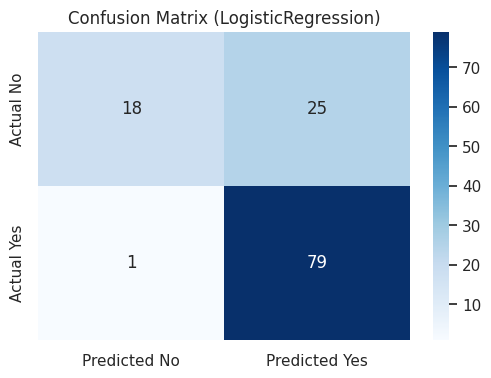

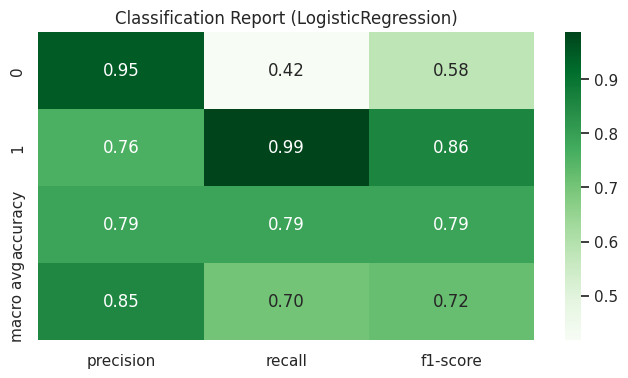

In [9]:
# ===============================
# 8️⃣ LOGISTIC REGRESSION
# ===============================
print("=== Logistic Regression ===")
log_model = LogisticRegression(max_iter=1000, random_state=42)
acc_lr, y_pred_lr, report_lr = evaluate_model(log_model, X_train_sel, X_test_sel, y_train, y_test)

=== K-Nearest Neighbors ===
Accuracy: 0.7886


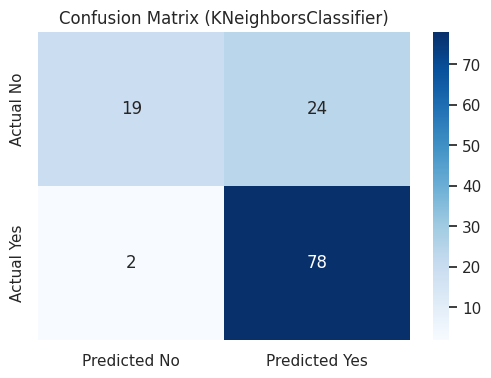

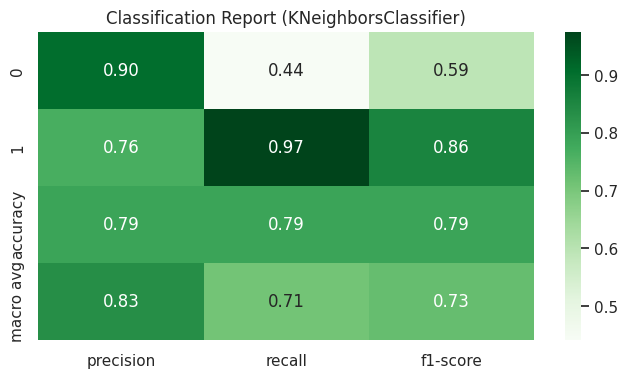

Best KNN Params: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'uniform'}


In [10]:
# ===============================
# 9️⃣ K-NEAREST NEIGHBORS
# ===============================
print("=== K-Nearest Neighbors ===")
knn_model = KNeighborsClassifier(n_neighbors=5)
acc_knn, y_pred_knn, report_knn = evaluate_model(knn_model, X_train_sel, X_test_sel, y_train, y_test)

# Hyperparameter Tuning for KNN using GridSearchCV
knn_params = {
    'n_neighbors': range(1,21),
    'metric': ['euclidean','manhattan'],
    'weights': ['uniform','distance']
}
grid_knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train_sel, y_train)
print("Best KNN Params:", grid_knn.best_params_)

=== Decision Tree ===
Accuracy: 0.6992


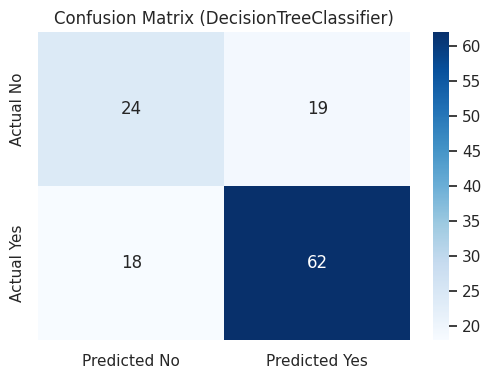

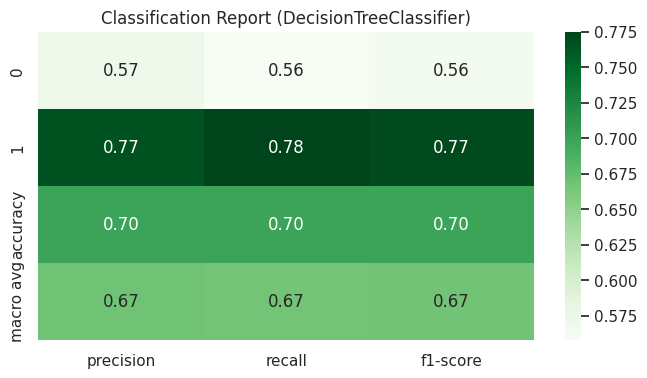

Best DT Params: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Accuracy: 0.7886


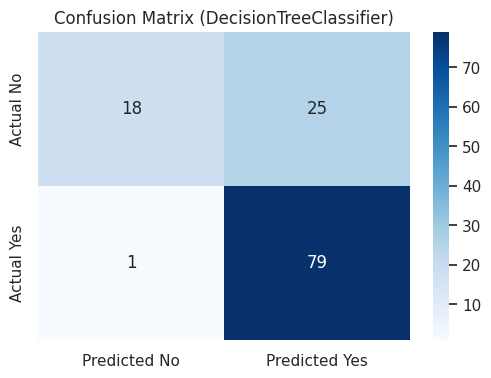

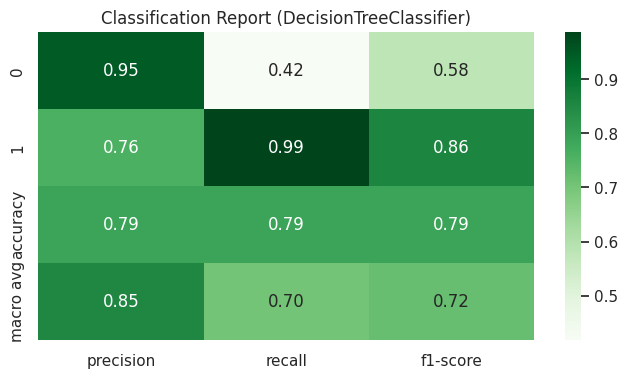

In [11]:
# ===============================
# 🔟 DECISION TREE
# ===============================
print("=== Decision Tree ===")
dt_model = DecisionTreeClassifier(random_state=42)
acc_dt, y_pred_dt, report_dt = evaluate_model(dt_model, X_train_sel, X_test_sel, y_train, y_test)

# Decision Tree Tuning
dt_params = {
    'max_depth': [3,5,7,None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,5]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train_sel, y_train)
best_dt = grid_dt.best_estimator_
print("Best DT Params:", grid_dt.best_params_)

# Evaluate tuned DT
acc_dt_best, _, _ = evaluate_model(best_dt, X_train_sel, X_test_sel, y_train, y_test)

=== Random Forest ===
Accuracy: 0.7642


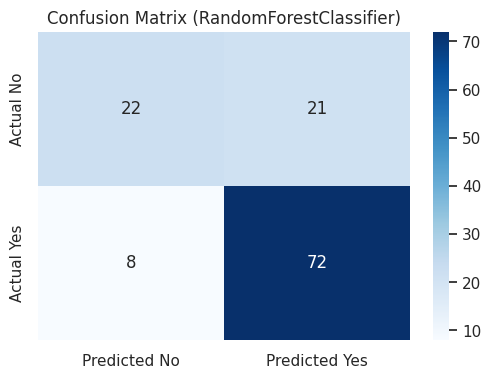

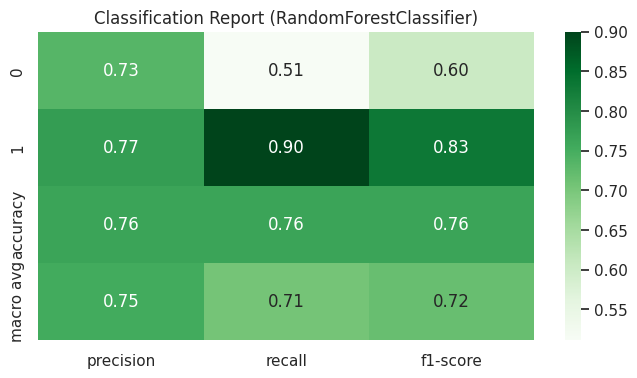

In [ ]:
# ===============================
# 1️⃣1️⃣ RANDOM FOREST
# ===============================
print("=== Random Forest ===")
rf_model = RandomForestClassifier(random_state=42)
acc_rf, y_pred_rf, report_rf = evaluate_model(rf_model, X_train_sel, X_test_sel, y_train, y_test)

# Random Forest Hyperparameter Tuning
rf_params = {
    'n_estimators': [50,100,150],
    'max_depth': [3,5,7,None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'max_features':['sqrt','log2']
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_sel, y_train)
best_rf = grid_rf.best_estimator_
print("Best RF Params:", grid_rf.best_params_)

# Evaluate tuned RF
acc_rf_best, _, _ = evaluate_model(best_rf, X_train_sel, X_test_sel, y_train, y_test)

In [ ]:
# ===============================
# 1️⃣2️⃣ XGBOOST
# ===============================
print("=== XGBoost ===")
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
acc_xgb, y_pred_xgb, report_xgb = evaluate_model(xgb_model, X_train_sel, X_test_sel, y_train, y_test)

In [ ]:
# ===============================
# 1️⃣3️⃣ FINAL MODELS COMPARISON
# ===============================
results = [
    {"Model":"Logistic Regression", "Accuracy":acc_lr},
    {"Model":"KNN", "Accuracy":acc_knn},
    {"Model":"Decision Tree", "Accuracy":acc_dt_best},
    {"Model":"Random Forest", "Accuracy":acc_rf_best},
    {"Model":"XGBoost", "Accuracy":acc_xgb}
]

results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("=== Model Comparison ===")
print(results_df)

# Visualization
plt.figure(figsize=(8,4))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlim(0,1)
plt.show()